In [1]:
%matplotlib inline
import numpy as np
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import pandas as pd
import dask
import os.path
from __future__ import division
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.rcParams['contour.negative_linestyle']= 'dashed'
plt.rcParams['image.cmap'] = 'RdBu'

from progress_bar import *
from useful import *

global data_dir
data_dir = '/scratch/ap587/dry_data/'

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
[array(253.2895334903858), array(257.319808124437), array(261.7636769901512), array(264.3473299096683), array(266.83337090035934), array(268.2360426592158), array(268.9377084564918), array(269.0973809601704), array(269.04830015630426), array(269.00593791375695)]


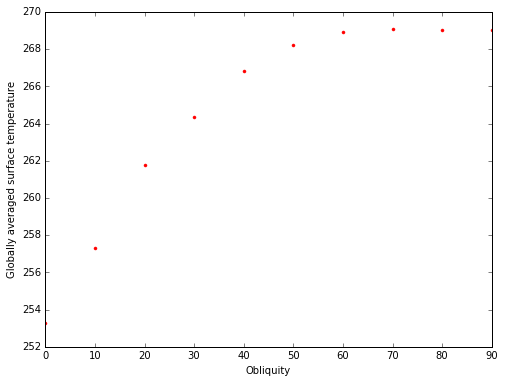

In [12]:
# Globally Averaged Surface Temperature
e = 'exp9'
exps = get_exps(data_dir+'processed/',e)

hc = 20.0
tmp = []
obls = []

for exp in exps:
    if 'hc{:.1f}'.format(hc) in exp:
        tmp.append(exp)
        obls.append(float(exp[15:]))
obls.sort()
tmp.sort()
exps = tmp

surf_temp = []
for exp in exps:
    ds = open_zmean_runset(data_dir, exp)
    ds = ds.isel(time=slice(720,None))
    
    surf_temp.append(ds.temp.isel(pfull=-1).mean('time').mean('lat').values)
    
print obls
print surf_temp

fig, ax = plt.subplots()
ax.plot(obls, surf_temp, 'r.')
ax.set_xlabel('Obliquity')
ax.set_ylabel('Globally averaged surface temperature')

In [3]:
def calc_emf(ds):
    '''
    Eddy momentum flux calculation
    Inputs:
        ds: xarray dataset containing at minimum fields (ucomp, vcomp, ucomp_vcomp)
    Outputs:
        ds: modified dataset with emf fields added
    '''
    
    uv = -86400. * (ds.ucomp_vcomp - ds.ucomp*ds.vcomp)
    uv_dy = gr.ddy(uv, uv=True)
    
    uw = -86400. * (ds.ucomp_omega - ds.ucomp*ds.omega)
    uw_dy = gr.ddp(uw)

    
    ds['uv'] = (('time', 'pfull', 'lat', 'lon'), uv)
    ds['uv_dy'] = (('time', 'pfull', 'lat', 'lon'), uv_dy)
    ds['uw'] = (('time', 'pfull', 'lat', 'lon'), uw)
    ds['uw_dy'] = (('time', 'pfull', 'lat', 'lon'), uw_dy)   
    return ds

In [2]:
exp = 'exp9v1_hc30.0-obl30.0'
ds = open_runset(data_dir, exp, runs=range(0,100))
ds

<xarray.Dataset>
Dimensions:      (lat: 64, latb: 65, lon: 128, lonb: 129, pfull: 32, phalf: 33, time: 1800)
Coordinates:
  * phalf        (phalf) float64 0.0 31.25 62.5 93.75 125.0 156.2 187.5 ...
  * latb         (latb) float64 -90.0 -86.58 -83.76 -80.96 -78.16 -75.36 ...
  * lonb         (lonb) float64 -1.406 1.406 4.219 7.031 9.844 12.66 15.47 ...
  * lon          (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 19.69 ...
  * pfull        (pfull) float64 11.5 45.98 77.6 109.0 140.3 171.6 202.9 ...
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * time         (time) float64 24.0 48.0 72.0 96.0 120.0 144.0 168.0 192.0 ...
Data variables:
    ucomp        (time, pfull, lat, lon) float64 -0.03338 -0.03211 -0.03089 ...
    h_trop       (time, lat, lon) float64 5.531 5.531 5.531 5.531 5.531 ...
    ucomp_omega  (time, pfull, lat, lon) float64 4.507e-07 4.315e-07 ...
    vcomp        (time, pfull, lat, lon) float64 -0.02462 -0.0239 -0.02311 ...
    heig

In [4]:
ds = calc_emf(ds)